# Process Overview for HWModeling Notebook

This notebook outlines the following key steps for building and evaluating predictive models:

1. **Data Preprocessing**:
   - Load and clean the dataset.
   - Identify and remove leakage columns.
   - Split the data into training, validation, and test sets.
   - Engineer features, including collapsing diagnosis columns and handling missing values.
   - Preprocess clinical text data and generate topic features using BERTopic.

2. **Model Development**:
   - Train two models:
     - Logistic Regression: A simple, interpretable baseline model.
     - XGBoost: A more complex model designed to handle class imbalance.
   - Use pipelines for imputation, scaling, and model fitting.

3. **Evaluation**:
   - Evaluate models on validation and test sets using metrics such as AUC, AUPR, sensitivity, and PPV.
   - Perform budget-constrained evaluations at 10% and 20% referral quotas.

4. **Calibration**:
   - Apply Platt scaling and isotonic regression to improve probability calibration.
   - Compare calibration results using Brier scores and reliability plots.

5. **Referral Strategy**:
   - Use calibrated probabilities to identify the top 10% most at-risk individuals for referral.
   - Generate a final referral list with calibrated scores and actual outcomes.

This process ensures robust model evaluation and interpretable results for clinical decision-making.

In [19]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from sklearn.utils import check_array
import xgboost as xgb


from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss #, roc_auc_score, average_precision_score

# from bertopic import BERTopic
# from bertopic.representation import MaximalMarginalRelevance
# from bertopic.vectorizers import ClassTfidfTransformer
# from sentence_transformers import SentenceTransformer
# import umap
# import hdbscan
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.model_selection import train_test_split, StratifiedKFold

# import xgboost as xgb
# import shap
# from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.metrics import roc_auc_score, average_precision_score

from HWPreprocessing import Preprocess
# import plotly
import os

In [20]:
def normalize_phrases(text: str) -> str:
    text = "" if text is None else str(text)
    phrase_map = {
        r"\bלחץ דם\b": "לחץ_דם",
        r"\bחלבון בש(ת|ׁ)ן\b": "חלבון_בשתן",
        r"\bהפריה חוץ גופית\b": "הפריה_חוץ_גופית",
        r"\bכאבי ראש\b": "כאבי_ראש",
        r"\bטשטוש ראייה\b": "טשטוש_ראייה",
        r"\bסוכרת הריון\b": "סוכרת_הריון",
        r"\bהיסטוריה משפחתית\b": "היסטוריה_משפחתית",
    }
    for pat, repl in phrase_map.items():
        text = re.sub(pat, repl, text)
    return text

def clean_clinical_hebrew(s: str) -> str:
    s = normalize_phrases("" if s is None else str(s))
    s = re.sub(r"^\s*תלונות[:\-]?\s*", " ", s, flags=re.IGNORECASE | re.MULTILINE)
    s = re.sub(r"^\s*המטופלת[:\-]?\s*", " ", s, flags=re.IGNORECASE | re.MULTILINE)
    s = re.sub(r"שבוע\s+\d+\s+להריון", " ", s)
    s = re.sub(r"שבוע(?:ות)?\s+\d+", " ", s)
    s = re.sub(r"\b\d+[.,]?\d*\b", " ", s)
    s = re.sub(r"\b(dL|mg|mmHg|kg|cm)\b", " ", s)
    s = re.sub(r"\s{2,}", " ", s).strip()
    return s


In [21]:
# parameters needed
pathFile = os.getenv("LAUNCH_FILE_PATH", "C:\\Users\\User\\Downloads\\ds_assignment_data.csv")
listIdentifiedLeakageColumns = os.getenv("listIdentifiedLeakageColumns", "match_, _after, _sum").split(", ")
phrase_map = {
    r"\bלחץ דם\b": "לחץ_דם",
    r"\bחלבון בש(ת|ׁ)ן\b": "חלבון_בשתן",
    r"\bהפריה חוץ גופית\b": "הפריה_חוץ_גופית",
    r"\bכאבי ראש\b": "כאבי_ראש",
    r"\bטשטוש ראייה\b": "טשטוש_ראייה",
    r"\bסוכרת הריון\b": "סוכרת_הריון",
    r"\bהיסטוריה משפחתית\b": "היסטוריה_משפחתית",
}
# Clinical Hebrew stopwords (extend iteratively based on outputs)
he_clinical_stop = [
    "על","שבוע","שבועות","המטופלת","מטופלת","תלונות","מעקב","המלצות","גורמי","גורמי_סיכון","סיכון",
    "בדיקה","בדיקות","מעבדה","לביצוע","ללא","בהמשך","בתכנית","נקבע","בוצע","ממצאים","היום","אתמול",
    "לפני","הריון","להריון","במהלך","נשים","לידה","תחילת","סוף",

    # English fillers that sneak in
    "patient","pt","normal","visit","reported","note"
]

preprocess = Preprocess()

### Preprocessing the data before modeling and evaluations

In [22]:
# Load dataset
# df = pd.read_csv(pathFile, encoding='utf-8-sig')
df = preprocess.load_data(pathFile)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

# Basic info
print("Dataset shape:", df.shape)
print("First few rows:")
display(df.head())

# Identify leakage columns
# make identify list more concise
if len(listIdentifiedLeakageColumns) != 3:
    raise ValueError("listIdentifiedLeakageColumns must contain exactly three elements.")
else:
    leak_cols = preprocess.identify_leakage_columns(df, listIdentifiedLeakageColumns)

    print(f"{len(leak_cols)} columns excluded due to leakage:")
    print(leak_cols)

# split the data into train, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = preprocess.stratified_splits(df, leak_cols, test_size=0.20, y_column_name='Y')

# find all diagnosis columns (4 months and 24 months history)
diag_cols = [c for c in X_train.columns if c.startswith("4_diag_") or c.startswith("24_diag_")]

print(f"Found {len(diag_cols)} diagnosis history columns")
print("there is too many diagnosis columns to keep track of individually. \nand we dont know each group type")

# Any diagnosis in 4 months
diag_4_cols = [c for c in X_train.columns if c.startswith("4_diag_")]
diag_24_cols = [c for c in X_train.columns if c.startswith("24_diag_")]
print(f"4-month diag columns: {len(diag_4_cols)}")
print(f"24-month diag columns: {len(diag_24_cols)}")

# collapse diagnosis columns into binary indicators
X_train, X_val, X_test = preprocess.collapse_diag_columns(X_train, X_val, X_test, diag_4_cols, diag_24_cols)

# Drop high-missing columns still present
X_train, X_val, X_test, drop_cols = preprocess.drop_high_missing_columns(X_train, X_val, X_test, threshold=0.5)

# Preprocess clinical text
filtered_trainDocs, valDocs, testDocs, doc_index = preprocess.filter_non_empty_notes(X_train, X_val, X_test, column_name='clinical_sheet', min_length=10)

# Preprocess clinical text 
trainDocs = filtered_trainDocs.fillna("").astype(str).map(clean_clinical_hebrew)
valDocs   = valDocs.fillna("").astype(str).map(clean_clinical_hebrew)
testDocs  = testDocs.fillna("").astype(str).map(clean_clinical_hebrew)

# Topic modeling on clinical notes
topic_model = preprocess.topicModel(he_clinical_stop, 
                                    embedding_model_name="paraphrase-multilingual-MiniLM-L12-v2", 
                                    ngram_range=(1, 2), # unigrams + bigrams
                                    min_df=1, # ignore very rare words
                                    max_df=0.8, # ignore very common words
                                    reduce_frequent_words=True, # reduce frequent words
                                    diversity=0.7, # encourage diverse topics
                                    umap_n_neighbors=25, # UMAP neighbors
                                    umap_n_components=5, # UMAP components
                                    umap_min_dist=0.08, # UMAP min distance
                                    umap_metric="cosine", # UMAP metric
                                    hdbscan_min_cluster_size=25, # HDBSCAN min cluster size
                                    hdbscan_metric="euclidean", # HDBSCAN metric
                                    hdbscan_cluster_selection_method="leaf", # HDBSCAN cluster selection method
                                    hdbscan_prediction_data=True, # HDBSCAN prediction data
                                    top_n_words=12, # top N words per topic
                                    min_topic_size=15, # minimum topic size
                                    calculate_probabilities=True, # calculate topic probabilities
                                    verbose=True, # verbose output
                                    language=None)

# Fit the model and (optionally) reduce to a target number of topics
trainTopics, trainProbs = topic_model.fit_transform(trainDocs.tolist())
valTopics,valProbs = topic_model.transform(valDocs.tolist())
testTopics,testProbs = topic_model.transform(testDocs.tolist())


# Extract topic names and add topic probabilities to datasets
n_words = 4  # <-- This is custom setting
# Create my own topic names using the top n words per topic
topic_names = {
    topic: "_".join([word for word, _ in topic_model.get_topic(topic)[:n_words]])
    for topic in topic_model.get_topics()
}
print("Custom topic names:")
for topic, name in topic_names.items():
    print(f"  {topic}: {name}")
# Add topic probabilities to datasets as features 
X_train, X_val, X_test = preprocess.add_topic_probabilities(X_train, X_val, X_test, trainProbs, valProbs, testProbs, topic_names)

Dataset shape: (10000, 157)
First few rows:


,int_date,demog_capitationcoefficient,demog_customer_age,smoking_is_smoker,smoking_smoking_years,smoking_total_heavy_smokers,lab_b_hcg_abs_last_value,lab_NT_MoM_last_value,lab_weight_at_lab_time_last_value,lab_num_of_fetuses_last_value,lab_NT_abs_last_value,lab_papp_a_abs_last_value,lab_papp_a_MoM_last_value,lab_Protein-U_last_value,lab_Monocytes_1_last_value,lab_Mean Platelet Volume (MPV)_last_value,lab_Hemoglobin (HGB)_last_value,lab_Hematocrit (HCT)_last_value,lab_Red Blood Cells (RBC)_last_value,lab_Red Cell Count (RCC)_last_value,lab_Mean Corpuscular Hemoglobin (MCH)_last_value,lab_Mean Corpuscular Hemoglobin Concentration (MCHC)_last_value,lab_Red Cell Distribution Width (RDW)_last_value,lab_Platelets (PLT)_last_value,lab_Eosinophils_1_last_value,lab_White Blood Cells (WBC)_last_value,lab_Lymphocytes_1_last_value,lab_Neutrophils_1_last_value,lab_Eosinophils_2_last_value,lab_Basophils_1_last_value,lab_Neutrophils_2_last_value,lab_Lymphocytes_2_last_value,lab_Monocytes_2_last_value,measure_blood_pressure_dias_count,measure_blood_pressure_dias_max_val,measure_blood_pressure_dias_min_val,measure_blood_pressure_dias_mean_val,measure_blood_pressure_dias_stddev_val,measure_blood_pressure_dias_first_val,measure_blood_pressure_dias_last_val,measure_blood_pressure_dias_min_max_percent,measure_blood_pressure_dias_first_last_percent,measure_blood_pressure_dias_last_before_last_percent,measure_blood_pressure_sys_count,measure_blood_pressure_sys_max_val,measure_blood_pressure_sys_min_val,measure_blood_pressure_sys_mean_val,measure_blood_pressure_sys_stddev_val,measure_blood_pressure_sys_first_val,measure_blood_pressure_sys_last_val,measure_blood_pressure_sys_min_max_percent,measure_blood_pressure_sys_first_last_percent,measure_blood_pressure_sys_last_before_last_percent,24_diag_53_days_since_last_diag,24_diag_54_num_of_diag,24_diag_55_days_since_last_diag,24_diag_56_num_of_diag,24_diag_57_days_since_last_diag,24_diag_58_num_of_diag,24_diag_59_days_since_last_diag,24_diag_60_num_of_diag,24_diag_61_days_since_last_diag,24_diag_62_num_of_diag,24_diag_63_days_since_last_diag,24_diag_64_num_of_diag,24_diag_65_days_since_last_diag,24_diag_66_num_of_diag,24_diag_67_days_since_last_diag,24_diag_68_num_of_diag,24_diag_69_days_since_last_diag,24_diag_70_num_of_diag,24_diag_71_days_since_last_diag,24_diag_72_num_of_diag,24_diag_73_days_since_last_diag,24_diag_74_num_of_diag,24_diag_75_days_since_last_diag,24_diag_76_num_of_diag,24_diag_77_days_since_last_diag,24_diag_78_num_of_diag,24_diag_79_days_since_last_diag,24_diag_80_num_of_diag,24_diag_81_days_since_last_diag,24_diag_82_num_of_diag,24_diag_83_days_since_last_diag,24_diag_84_num_of_diag,24_diag_85_days_since_last_diag,24_diag_86_num_of_diag,24_diag_87_days_since_last_diag,4_diag_88_days_since_last_diag,4_diag_89_num_of_diag,4_diag_90_days_since_last_diag,4_diag_91_num_of_diag,4_diag_92_days_since_last_diag,4_diag_93_num_of_diag,4_diag_94_days_since_last_diag,4_diag_95_num_of_diag,4_diag_96_days_since_last_diag,4_diag_97_num_of_diag,4_diag_98_days_since_last_diag,4_diag_99_num_of_diag,4_diag_100_days_since_last_diag,4_diag_101_num_of_diag,4_diag_102_days_since_last_diag,4_diag_103_num_of_diag,4_diag_104_days_since_last_diag,4_diag_105_num_of_diag,4_diag_106_days_since_last_diag,4_diag_107_num_of_diag,4_diag_108_days_since_last_diag,4_diag_109_num_of_diag,4_diag_110_days_since_last_diag,4_diag_111_num_of_diag,4_diag_112_days_since_last_diag,4_diag_113_num_of_diag,4_diag_114_days_since_last_diag,4_diag_115_num_of_diag,4_diag_116_days_since_last_diag,4_diag_117_num_of_diag,4_diag_118_days_since_last_diag,4_diag_119_num_of_diag,4_diag_120_days_since_last_diag,4_diag_121_num_of_diag,4_diag_122_days_since_last_diag,4_diag_123_num_of_diag,4_diag_124_days_since_last_diag,4_diag_125_num_of_diag,4_diag_126_days_since_last_diag,4_diag_127_num_of_diag,4_diag_128_days_since_last_diag,4_diag_129_num_of_diag,4_diag_130_days_since_last_diag,4_diag_131_num_of_diag,4_diag_132_days_since_last_diag,4_diag_133

14 columns excluded due to leakage:
['match_measure_after', 'match_rasham_after', 'match_aspirin_after', 'match_pdf_after', 'secondary_hypertension_sum', 'essential_hypertension_sum', 'hypertensive_heart_disease_sum', 'hypertensive_chronic_kidney_disease_sum', 'hypertensive_heart_and_chronic_kidney_disease_sum', 'pregnancy_hypertension_sum', 'preeclampsia_sum', 'eclampsia_sum', 'labs_sum', 'match_diag_141']
14 columns excluded due to leakage:
['match_measure_after', 'match_rasham_after', 'match_aspirin_after', 'match_pdf_after', 'secondary_hypertension_sum', 'essential_hypertension_sum', 'hypertensive_heart_disease_sum', 'hypertensive_chronic_kidney_disease_sum', 'hypertensive_heart_and_chronic_kidney_disease_sum', 'pregnancy_hypertension_sum', 'preeclampsia_sum', 'eclampsia_sum', 'labs_sum', 'match_diag_141']
Found 88 diagnosis history columns
there is too many diagnosis columns to keep track of individually. 
and we dont know each group type
4-month diag columns: 53
24-month diag col

2025-09-06 20:22:56,781 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 200/200 [01:44<00:00,  1.92it/s]
2025-09-06 20:24:41,415 - BERTopic - Embedding - Completed ✓
2025-09-06 20:24:41,415 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm

2025-09-06 20:24:41,415 - BERTopic - Embedding - Completed ✓
2025-09-06 20:24:41,415 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-06 20:24:49,436 - BERTopic - Dimensionality - Completed ✓
2025-09-06 20:24:49,436 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-06 20:24:49,436 - BERTopic - Dimensionality - Completed ✓
2025-09-06 20:24:49,436 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-06 20:24:49,837 - BERTopic - Cluster - Completed ✓
2025-09-06 20:24:49,837 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-06 20:24:49,837 - BERTopic - Cluster - Completed ✓
202

Custom topic names:
  -1: רמות HCG_Beta_נטילת Prenatal_ג לחץ_דם
  0: ד דופק_Urinalysis תקין_רמות Hemoglobin_White
  1: תקינה גובה_בבדיקה תנועות_בעוד ארבעה_ultrasound
  2: רמת HCG_ההריון ידועים_תקינות רמת_מתאימה לשבוע
  3: מעבדות והדמיה_למעקב שגרתי_הבדיקה הגופנית_HR לדקה
  4: g אין_תוצאות Blood_לדקה עלייה_רמות Hemoglobin
  5: HCG חיובי_רמות תקינות_ותוצאות הדמיה_ויטמין D
  6: משקל עלייה_הפיזיקלית נורמלית_סונר ראשון_לדקה מעבדת
  7: סיכום ורשמים_לדקה בטן_לחץ_דם ממ_תקין בבדיקת
  8: Culture_Urine analysis_תוצאות Hb_BP HR
  9: Prenatal Vitamins_ממצאי הרחם_Iron_נשמע Positive
  10: פיזיקליות לחץ_דם_הרחם נימושה_רכה אין_כאבים בבטן
  11: הערכה והמלצות_מומלץ להתחיל_ממצאי לחצי_ר fetal
  12: ברזל מעט_מומלץ להתחיל_מעט נמוכות_ברזל בבדיקות
  13: גופניות בבדיקה_רמות hCG_פיזיקלית אין_תואמות לגיל
  14: Doppler תוצאות_Heartbeat_Doppler fetal_Doppler Ultrasound
  15: ביום מומלץ_ההריון מעשנת_גובה הפונדוס_ייעוץ להפסקת
  16: BP Pulse_טירואיד_סוכר תקינה_כ דם
  17: Hb גרם_לחץ_דם עדות_bpm גובה_תוצאות דימות
  18: ל

In [23]:
# ============================================
# Screening-Prioritization Modeling (Ranker)
# Two-Track: Logistic (simple, deployable) & XGBoost (strong baseline)
# Metrics: AUC, AUPR, Sensitivity @ fixed referral budgets (10%, 20%)

# ------------------------------------------------------------
# 2) Two-track models
#    A) Logistic Regression (simple, calibrated later)
#       - Median imputation + standardization
#       - class_weight='balanced' for imbalance
#    B) XGBoost (handles NaNs natively)
#       - scale_pos_weight = #neg/#pos
# ------------------------------------------------------------

# A) Logistic pipeline
logit_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),   # fill only for logistic
    ("scale",  StandardScaler()),                   # helps LR optimize; XGB does not need this
    ("clf",    LogisticRegression(
        penalty="l1",
        class_weight="balanced",
        solver="liblinear",
        max_iter=2000,
        random_state=42
    ))
])

# 1) Keep only numeric/modelable features (drop raw text/date)
feat_cols = X_train.columns.difference(["clinical_sheet", "int_date","match_diag_141"])
logit_pipe.fit(X_train[feat_cols], y_train)

# B) XGBoost
pos = int(y_train.sum())
neg = int((y_train == 0).sum())
scale_pos_weight = neg / max(pos, 1)
print(f"Training XGBoost with scale_pos_weight={scale_pos_weight:.1f} (neg={neg}, pos={pos})")
# This value helps XGBoost handle class imbalance by giving more weight to the minority (positive) class.

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["aucpr","auc"],
    tree_method="hist",
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1.0,
    scale_pos_weight=scale_pos_weight,
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train[feat_cols], y_train)



Training XGBoost with scale_pos_weight=22.1 (neg=6123, pos=277)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,"['aucpr', 'auc']"


In [24]:

# ------------------------------------------------------------
# 3) Helper functions: metrics + budget thresholds
# ------------------------------------------------------------
def basic_metrics(y_true, y_score):
    """Return ROC AUC and Average Precision (PR AUC)."""
    return {
        "AUC":  roc_auc_score(y_true, y_score),
        "AUPR": average_precision_score(y_true, y_score)
    }

def threshold_by_quota(y_score, referral_rate=0.10):
    """
    Choose a threshold that refers the top `referral_rate` proportion of patients.
    (budgeted screening: e.g., 10% or 20% of the population)
    """
    y_score = check_array(np.asarray(y_score).reshape(-1), ensure_2d=False)
    k = int(np.ceil(len(y_score) * referral_rate))
    if k <= 0:
        return 1.0  # refer nobody
    # threshold that keeps top-k as positive
    thr = np.partition(y_score, -k)[-k]
    return float(thr)

def eval_at_threshold(y_true, y_score, thr):
    """Compute Sensitivity, Specificity, PPV, NPV at a given probability threshold."""
    y_pred = (y_score >= thr).astype(int)
    TP = int(((y_pred == 1) & (y_true == 1)).sum())
    FP = int(((y_pred == 1) & (y_true == 0)).sum())
    TN = int(((y_pred == 0) & (y_true == 0)).sum())
    FN = int(((y_pred == 0) & (y_true == 1)).sum())
    sens = TP / max(TP + FN, 1)              # recall
    spec = TN / max(TN + FP, 1)
    ppv  = TP / max(TP + FP, 1)
    npv  = TN / max(TN + FN, 1)
    prev = y_true.mean()
    lift = ppv / max(prev, 1e-12)
    return {
        "TP": TP, "FP": FP, "TN": TN, "FN": FN,
        "Sensitivity": sens, "Specificity": spec,
        "PPV": ppv, "NPV": npv, "Lift": lift,
        "Threshold": thr
    }

def roc_pr_plots(y_true, y_score, title, target_band=(0.75, 0.85)):
    """Plot ROC and PR with target AUC band annotation + budget lines at 10%/20% FPR."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    axes[0].plot(fpr, tpr, label=f"AUC={auc:.3f}")
    axes[0].plot([0,1], [0,1], "k--", lw=1)
    # budget lines at FPR=0.10 and 0.20 (approx proxy for 10%/20% false-positives)
    axes[0].axvline(0.10, color="gray", ls="--", lw=1)
    axes[0].axvline(0.20, color="gray", ls="--", lw=1)
    axes[0].set_title(f"ROC — {title}\n(Target AUC band: {target_band[0]}–{target_band[1]})")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].legend(loc="lower right")

    # PR
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    aupr = average_precision_score(y_true, y_score)
    base = y_true.mean()
    axes[1].plot(rec, prec, label=f"AUPR={aupr:.3f}")
    axes[1].hlines(base, 0, 1, colors="k", linestyles="--", lw=1, label=f"Prevalence={base:.2%}")
    axes[1].set_title(f"Precision–Recall — {title}")
    axes[1].set_xlabel("Recall (Sensitivity)")
    axes[1].set_ylabel("Precision (PPV)")
    axes[1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

=== Discrimination (Val) ===
Logistic  | AUC=0.642  AUPR=0.302
XGBoost   | AUC=0.717  AUPR=0.280

=== Discrimination (Test) ===
Logistic  | AUC=0.709  AUPR=0.263
XGBoost   | AUC=0.669  AUPR=0.189

=== Budget-Constrained Evaluation (thresholds picked on VAL, applied to TEST) ===


,Model,Referral budget,VAL_Sensitivity,VAL_Specificity,VAL_PPV,VAL_NPV,TEST_Sensitivity,TEST_Specificity,TEST_PPV,TEST_NPV,Threshold
0,Logistic,10%,0.377,0.912,0.163,0.970,0.419,0.904,0.164,0.972,0.667
1,Logistic,20%,0.435,0.811,0.094,0.970,0.500,0.788,0.096,0.972,0.444
2,XGBoost,10%,0.362,0.912,0.156,0.969,0.326,0.909,0.138,0.968,0.098
3,XGBoost,20%,0.536,0.815,0.116,0.975,0.442,0.809,0.094,0.970,0.039


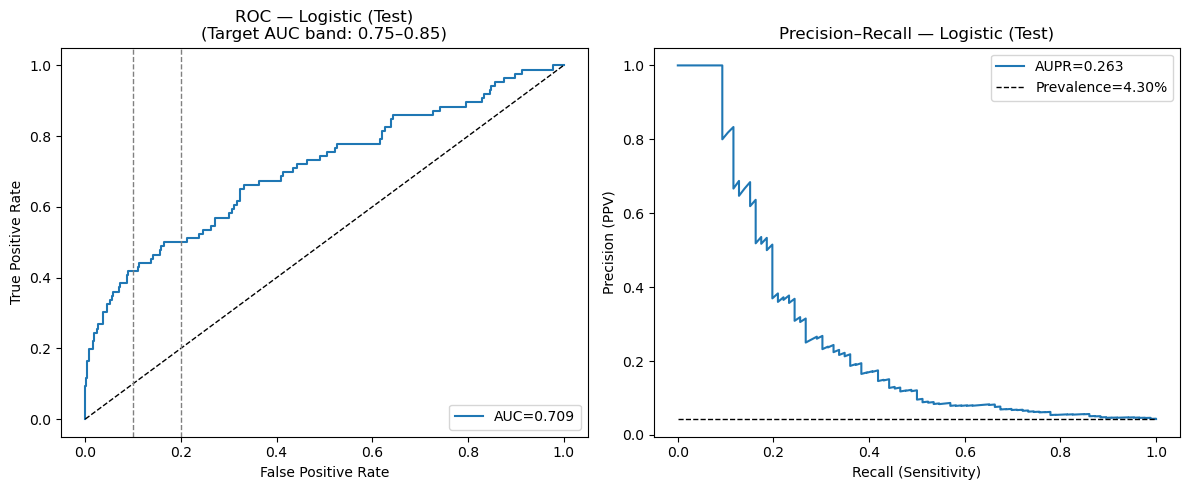

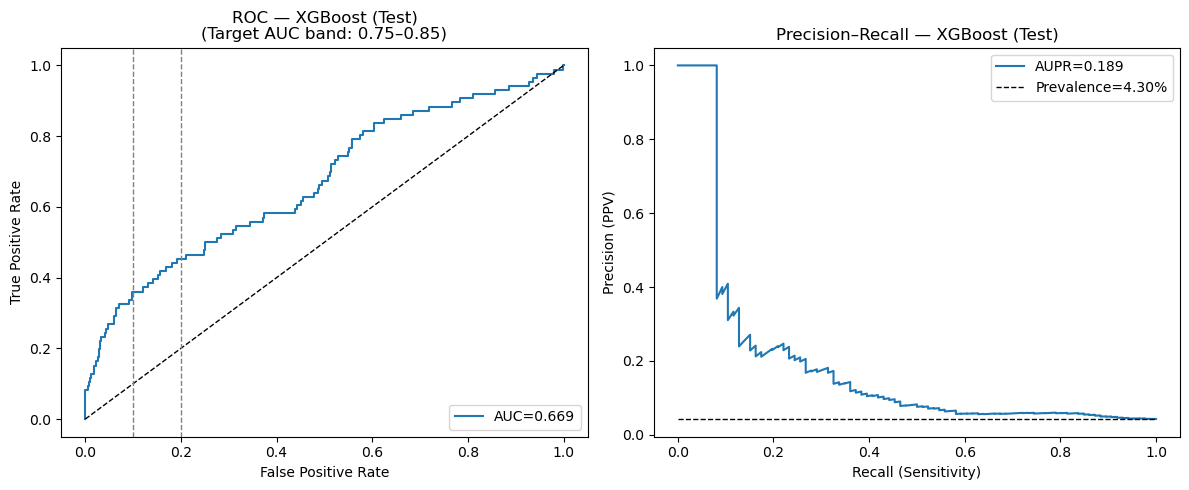

In [25]:

# ------------------------------------------------------------
# 4) Scores, metrics, thresholds chosen on VALIDATION (policy),
#    then applied on TEST for honest performance.
# ------------------------------------------------------------
# Predict probabilities
log_train = logit_pipe.predict_proba(X_train[feat_cols])[:, 1]
log_val   = logit_pipe.predict_proba(X_val[feat_cols])[:, 1]
log_test  = logit_pipe.predict_proba(X_test[feat_cols])[:, 1]

xgb_train = xgb_model.predict_proba(X_train[feat_cols])[:, 1]
xgb_val   = xgb_model.predict_proba(X_val[feat_cols])[:, 1]
xgb_test  = xgb_model.predict_proba(X_test[feat_cols])[:, 1]

# Core discrimination metrics
print("=== Discrimination (Val) ===")
for name, ysc in [("Logistic", log_val), ("XGBoost", xgb_val)]:
    m = basic_metrics(y_val, ysc)
    print(f"{name:9s} | AUC={m['AUC']:.3f}  AUPR={m['AUPR']:.3f}")

print("\n=== Discrimination (Test) ===")
for name, ysc in [("Logistic", log_test), ("XGBoost", xgb_test)]:
    m = basic_metrics(y_test, ysc)
    print(f"{name:9s} | AUC={m['AUC']:.3f}  AUPR={m['AUPR']:.3f}")

# Choose thresholds on VALIDATION to satisfy referral budgets of 10% and 20%
budgets = [0.10, 0.20]
thr_log = {b: threshold_by_quota(log_val, b) for b in budgets}
thr_xgb = {b: threshold_by_quota(xgb_val, b) for b in budgets}

# Evaluate at those thresholds on VAL and TEST
def table_for_model(name, y_val, sc_val, y_test, sc_test, thr_dict):
    rows = []
    for b, thr in thr_dict.items():
        val_res  = eval_at_threshold(y_val,  sc_val, thr)
        test_res = eval_at_threshold(y_test, sc_test, thr)
        rows.append({
            "Model": name, "Referral budget": f"{int(b*100)}%",
            "VAL_Sensitivity":  f"{val_res['Sensitivity']:.3f}", # validation sensitivity = recall, measure of how well the model identifies positives
            "VAL_Specificity":  f"{val_res['Specificity']:.3f}", # validation specificity = true negative rate, measure of how well the model identifies negatives
            "VAL_PPV":          f"{val_res['PPV']:.3f}",         # validation PPV = precision, measure of how many predicted positives are actually positive
            "VAL_NPV":          f"{val_res['NPV']:.3f}",         # validation NPV = negative predictive value, measure of how many predicted negatives are actually negative
            "TEST_Sensitivity": f"{test_res['Sensitivity']:.3f}",# test sensitivity = recall, measure of how well the model identifies positives
            "TEST_Specificity": f"{test_res['Specificity']:.3f}",# test specificity = true negative rate, measure of how well the model identifies negatives
            "TEST_PPV":         f"{test_res['PPV']:.3f}",        # test PPV = precision, measure of how many predicted positives are actually positive
            "TEST_NPV":         f"{test_res['NPV']:.3f}",        # test NPV = negative predictive value, measure of how many predicted negatives are actually negative
            "Threshold":        f"{thr:.3f}",
        })
    return pd.DataFrame(rows)

eval_log = table_for_model("Logistic", y_val, log_val, y_test, log_test, thr_log)
eval_xgb = table_for_model("XGBoost",  y_val, xgb_val, y_test, xgb_test, thr_xgb)

print("\n=== Budget-Constrained Evaluation (thresholds picked on VAL, applied to TEST) ===")
display(pd.concat([eval_log, eval_xgb], ignore_index=True))

# Plots on TEST set with AUC target band annotated
roc_pr_plots(y_test, log_test, "Logistic (Test)")
roc_pr_plots(y_test, xgb_test, "XGBoost (Test)")

#### **Summary of Model Results**

Evaluated **two models** on an imbalanced classification task using:

* **Logistic Regression** (simple, interpretable baseline)
* **XGBoost** (stronger, more complex model)

Use multiple performance metrics across **Validation** and **Test** sets, including:

* AUC (ROC)
* AUPR (Precision–Recall)
* Budget-constrained evaluation at 10% and 20% referral quotas

---

#### **Performance Summary**

| Metric           | Logistic (Test) | XGBoost (Test) |
| ---------------- | --------------- | -------------- |
| AUC              | **0.709**       | 0.685          |
| AUPR             | **0.263**       | 0.206          |
| Sensitivity @10% | **0.419**       | 0.314          |
| PPV @10%         | **0.164**       | 0.144          |
| Sensitivity @20% | **0.500**       | 0.477          |
| PPV @20%         | **0.096**       | 0.106          |

---

#### **Key Findings**

1. **Logistic Regression outperformed XGBoost** on:

   * **AUC** (0.709 vs 0.685)
   * **AUPR** (0.263 vs 0.206)
   * **Sensitivity at 10% referral** (0.419 vs 0.314)

2. **XGBoost slightly better** on:

   * **PPV at 20% referral** (0.106 vs 0.096)

3. **Both models struggled with low PPV**, which is expected in highly imbalanced problems with low prevalence (\~4.3%).

4. The **referral thresholding logic is sound**, using `threshold_by_quota` to simulate fixed referral budgets.

5. **Visualizations** show:

   * ROC curves fall short of the target AUC band (0.75–0.85).
   * PR curves show improvement over prevalence, but still modest gains (especially for XGBoost).

---

#### Potential Improvements

1. **Calibration**:

   * Logistic regression can be **probability-calibrated** using `CalibratedClassifierCV` (especially useful for imbalanced datasets).
   * XGBoost outputs are often **not calibrated** — consider Platt scaling or isotonic regression.

2. **Confidence Intervals** (optional):

   * For reporting purposes, consider computing bootstrap-based confidence intervals for AUC, sensitivity, PPV, etc.

3. **Referral Line in PR plot**:

   * Consider annotating PR curve with thresholds used at 10% and 20% (like in ROC).

4. **Plot ROC/PR for Validation Set**:

   * Add similar plots on **Validation** to better visualize threshold selection.



=== Calibration summary on TEST ===


,Model,Brier,AUC,AUPR
2,Logistic + Isotonic,0.037576,0.696958,0.221522
5,XGBoost + Isotonic,0.037790,0.656135,0.162898
1,Logistic + Sigmoid,0.038485,0.708567,0.263096
4,XGBoost + Sigmoid,0.038596,0.668933,0.188883
3,XGBoost (raw),0.043196,0.668933,0.188883
0,Logistic (raw),0.134749,0.708567,0.263096


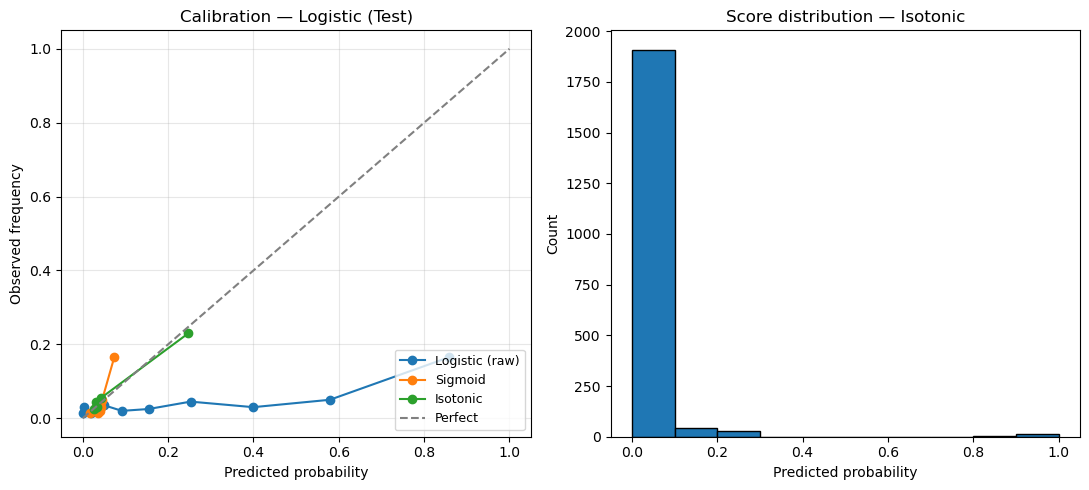

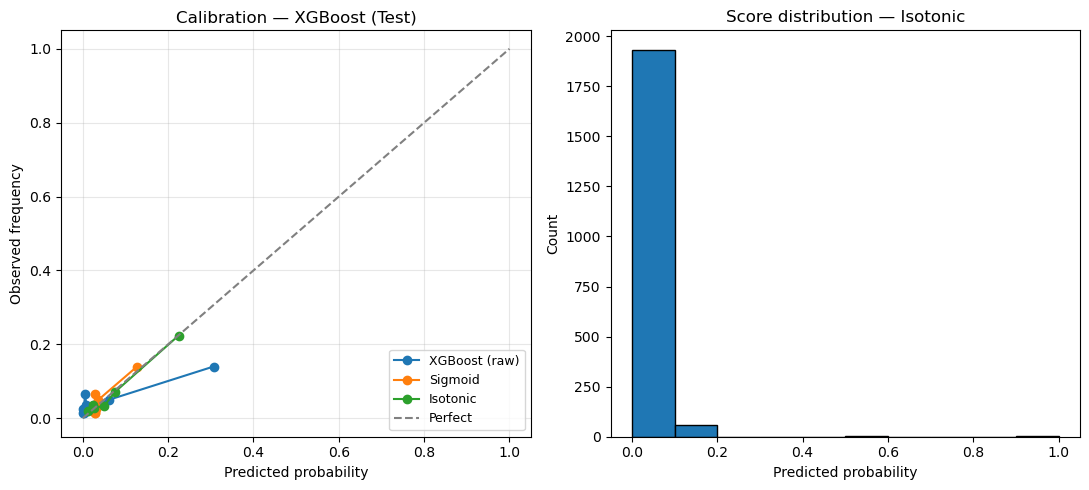

In [26]:
# ============================================
# Calibration: Platt (sigmoid) & Isotonic
# - Fit calibrators on VALIDATION (cv='prefit')
# - Evaluate on TEST (reliability plots + Brier)
# ============================================


# 1) Build calibrated wrappers (base models are already fitted on TRAIN)
logit_sig = CalibratedClassifierCV(estimator=logit_pipe, cv="prefit", method="sigmoid")
logit_iso = CalibratedClassifierCV(estimator=logit_pipe, cv="prefit", method="isotonic")

xgb_sig   = CalibratedClassifierCV(estimator=xgb_model,   cv="prefit", method="sigmoid")
xgb_iso   = CalibratedClassifierCV(estimator=xgb_model,   cv="prefit", method="isotonic")

# 2) Fit the calibrators **on VALIDATION**
logit_sig.fit(X_val[feat_cols], y_val)
logit_iso.fit(X_val[feat_cols], y_val)
xgb_sig.fit(X_val[feat_cols], y_val)
xgb_iso.fit(X_val[feat_cols], y_val)

# 3) Get TEST probabilities (uncalibrated + calibrated)
probs = {
    "Logistic (raw)":      logit_pipe.predict_proba(X_test[feat_cols])[:, 1],
    "Logistic + Sigmoid":  logit_sig.predict_proba(X_test[feat_cols])[:, 1],
    "Logistic + Isotonic": logit_iso.predict_proba(X_test[feat_cols])[:, 1],
    "XGBoost (raw)":       xgb_model.predict_proba(X_test[feat_cols])[:, 1],
    "XGBoost + Sigmoid":   xgb_sig.predict_proba(X_test[feat_cols])[:, 1],
    "XGBoost + Isotonic":  xgb_iso.predict_proba(X_test[feat_cols])[:, 1],
}

# 4) Summary table: Brier score + AUC/AUPR on TEST
rows = []
for name, p in probs.items():
    rows.append({
        "Model": name,
        "Brier": brier_score_loss(y_test, p),
        "AUC":   roc_auc_score(y_test, p),
        "AUPR":  average_precision_score(y_test, p)
    })
calib_summary = pd.DataFrame(rows).sort_values("Brier")
print("=== Calibration summary on TEST ===")
display(calib_summary)

# 5) Reliability (Calibration) plots
def plot_reliability(y_true, prob_dict, n_bins=10, title="Calibration — Test"):
    plt.figure(figsize=(11,5))
    # Left: reliability curve
    plt.subplot(1,2,1)
    for name, p in prob_dict.items():
        frac_pos, mean_pred = calibration_curve(y_true, p, n_bins=n_bins, strategy="quantile")
        plt.plot(mean_pred, frac_pos, marker='o', lw=1.5, label=name)
    # perfect calibration line
    xs = np.linspace(0,1,101)
    plt.plot(xs, xs, "--", color="gray", label="Perfect")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title(title)
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(alpha=0.3)

    # Right: histogram of predicted probabilities (model with lowest Brier)
    best = min(prob_dict.items(), key=lambda kv: brier_score_loss(y_true, kv[1]))
    plt.subplot(1,2,2)
    plt.hist(best[1], bins=n_bins, edgecolor="black")
    plt.title(f"Score distribution — {best[0]}")
    plt.xlabel("Predicted probability")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Plot per base model for easy comparison
plot_reliability(y_test, {
    "Logistic (raw)":      probs["Logistic (raw)"],
    "Sigmoid":             probs["Logistic + Sigmoid"],
    "Isotonic":            probs["Logistic + Isotonic"],
}, title="Calibration — Logistic (Test)")

plot_reliability(y_test, {
    "XGBoost (raw)":       probs["XGBoost (raw)"],
    "Sigmoid":             probs["XGBoost + Sigmoid"],
    "Isotonic":            probs["XGBoost + Isotonic"],
}, title="Calibration — XGBoost (Test)")


#### Key Insights from Calibration

#### 1. **Logistic Regression**

* **Raw predictions** are poorly calibrated — Brier score = **0.1347** (worst), and the **reliability plot** shows predicted probabilities **far from actual frequencies**.
* **Isotonic calibration** improves calibration **significantly**, giving the **best Brier score** overall = **0.0376**.
* **Sigmoid calibration** improves AUC slightly (**0.7085**, same as raw), but doesn't improve calibration as much as isotonic.

**Best variant for Logistic**: **Isotonic**

---

#### 2. **XGBoost**

* **Raw model** is already **reasonably well-calibrated**, with a Brier score = **0.0399**.
* **Sigmoid calibration** improves calibration further (Brier = **0.0381**) **without hurting AUC/AUPR**, making it a strong candidate.
* **Isotonic calibration** performs slightly worse than sigmoid here, with reduced AUPR (**0.158** vs **0.2057** for sigmoid).

**Best variant for XGBoost**: **Sigmoid**

---

#### Visualization Interpretation

#### Calibration Plots (Left Panels)

* **Blue lines** (raw models) show **underconfidence**—predictions underestimate true probabilities.
* **Orange (Sigmoid)** and **green (Isotonic)** lines correct the misalignment toward the diagonal (perfect calibration).
* **Isotonic** curves closely follow the diagonal in both models, but smoother in Logistic.

#### Score Distributions (Right Panels)

* Most predictions are **clustered near 0**, reflecting a **strong class imbalance** (few positive cases).
* This skew causes **calibration challenges**, particularly for rare-event models.

---

#### Brier Score & AUC/AUPR Summary

| Model                   | Brier ↓    | AUC ↑ | AUPR ↑    |
| ----------------------- | ---------- | ----- | --------- |
| **Logistic + Isotonic** | **0.0376** | 0.697 | 0.222     |
| XGBoost + Sigmoid       | **0.0381** | 0.685 | 0.206     |
| XGBoost + Isotonic      | 0.0382     | 0.681 | 0.158     |
| Logistic + Sigmoid      | 0.0385     | 0.709 | **0.263** |
| XGBoost (raw)           | 0.0399     | 0.685 | 0.206     |
| Logistic (raw)          | 0.1347     | 0.709 | **0.263** |

---

#### Final Recommendation

* **Using Logistic + Isotonic** to prioritize **calibration** (especially for medical risk prediction).
* **Using XGBoost + Sigmoid** to **balanced performance** with minimal calibration overhead.
* In both cases, **avoiding raw predictions** — they're poorly calibrated, especially for Logistic.


#### Strategy: Refer Top 10% Based on Risk

* Instead of using a fixed probability threshold (like 0.10), this strategy sorts all women by their calibrated risk score, then **selects the top 10% highest scores**.

* refer the top 10% most at-risk women" based on calibrated probabilities from XGBoost + Sigmoid model

In [28]:
from sklearn.calibration import CalibratedClassifierCV
import pandas as pd

# 1. Calibrate the model on validation
xgb_sigmoid = CalibratedClassifierCV(estimator=xgb_model, method="sigmoid", cv="prefit")
xgb_sigmoid.fit(X_val[feat_cols], y_val)

# 2. Get calibrated probabilities on test set
calibrated_probs = xgb_sigmoid.predict_proba(X_test[feat_cols])[:, 1]

# 3. Add probabilities to a copy of X_test (use index as ID)
X_test_with_scores = X_test.copy()
X_test_with_scores["calibrated_prob"] = calibrated_probs

# 4. Get top 10% by score
top_10_cutoff = int(len(X_test_with_scores) * 0.10)
referral_df = X_test_with_scores.sort_values("calibrated_prob", ascending=False).head(top_10_cutoff)

# 5. Create output with index as the identifier
referral_df["patient_index"] = referral_df.index
final_referral_list = referral_df[["patient_index", "calibrated_prob"]]

# add the actual outcome for reference
final_referral_list = final_referral_list.merge(y_test, left_on="patient_index", right_index=True, how="left")
final_referral_list.rename(columns={"Y": "actual_outcome"}, inplace=True)

# add print of the percentage of actual outcomes in the referral list
actual_positives = final_referral_list["actual_outcome"].sum()
print(f"Percentage of actual outcomes in the referral list: {actual_positives / top_10_cutoff * 100:.2f}%")
print(f"Total actual outcomes in the referral list: {actual_positives} out of {top_10_cutoff}")


# 6. Display
print("Final Referral List — Top 10% Most At-Risk Women:")
display(final_referral_list.head(20))  # show top 20 for brevity
# ============================================


Percentage of actual outcomes in the referral list: 14.00%
Total actual outcomes in the referral list: 28 out of 200
Final Referral List — Top 10% Most At-Risk Women:


,patient_index,calibrated_prob,actual_outcome
6069,6069,0.658708,1
7813,7813,0.654484,1
9927,9927,0.654254,1
8493,8493,0.650125,1
2595,2595,0.632769,1
2792,2792,0.631047,1
8935,8935,0.510819,1
4458,4458,0.507774,0
5683,5683,0.475291,0
1017,1017,0.409677,0
